In [9]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng

rng = default_rng()
'''This script generates a continuous signal and discrete observations of the signal. 
The signal is a constant acceleration model. 
The observations are generated by adding noise to the true signal. 
The signal is generated for a time interval [0, 50] with a time step of 0.01. 
The observations are generated at discrete points with a time step of 1. 
The initial condition is drawn from the same distribution used for the Kalman filter and ensemble Kalman filter. 
'''
# The continuous signal is only used for plotting.
t0 = 0
tf = 50
dt = 0.01
t_cont = np.arange(t0, tf, dt).T

# The initial condition is drawn from the same initial distribution used for the KF and EnKF.
# The true model is a constant acceleration model.
rng = default_rng(1)
m0 = np.array([15, -10, 0.5])
m_false = np.array([10,-9,0.3])
R0 = np.identity(3)

# The continuous signal is generated using the true model.
X_cont = np.empty((3, len(t_cont)))
X_cont[:, 0] = m0

for i_time in range(0, len(t_cont)-1):
    
    x = X_cont[0, i_time]
    v = X_cont[1, i_time]
    a = X_cont[2, i_time]

    dx = v*dt
    dv = a*dt
    da = 0*dt

    X_cont[:, i_time+1] = X_cont[:, i_time] + [dx, dv, da]

# The observations are only at discrete points. Because the system is linear, an explicit transition matrix can be given.
delta_t = 1
t_dis = np.arange(t0, tf, delta_t).T
X_dis = np.zeros((3, len(t_dis)))
X_dis[:, 0] = X_cont[:, 0]
F = np.array([[1, delta_t, 0.5*delta_t**2], [0, 1, delta_t], [0, 0, 1]])
for i_time in range(0, len(t_dis)-1):
    X_dis[:, i_time+1] = F@X_dis[:, i_time]

# The observations are generated by adding noise to the true signal.
R_obs = 1
H = np.array([[1, 0, 0]])
eps = rng.normal(0, np.sqrt(R_obs), (1, len(t_dis)))
Y = H@X_dis + eps


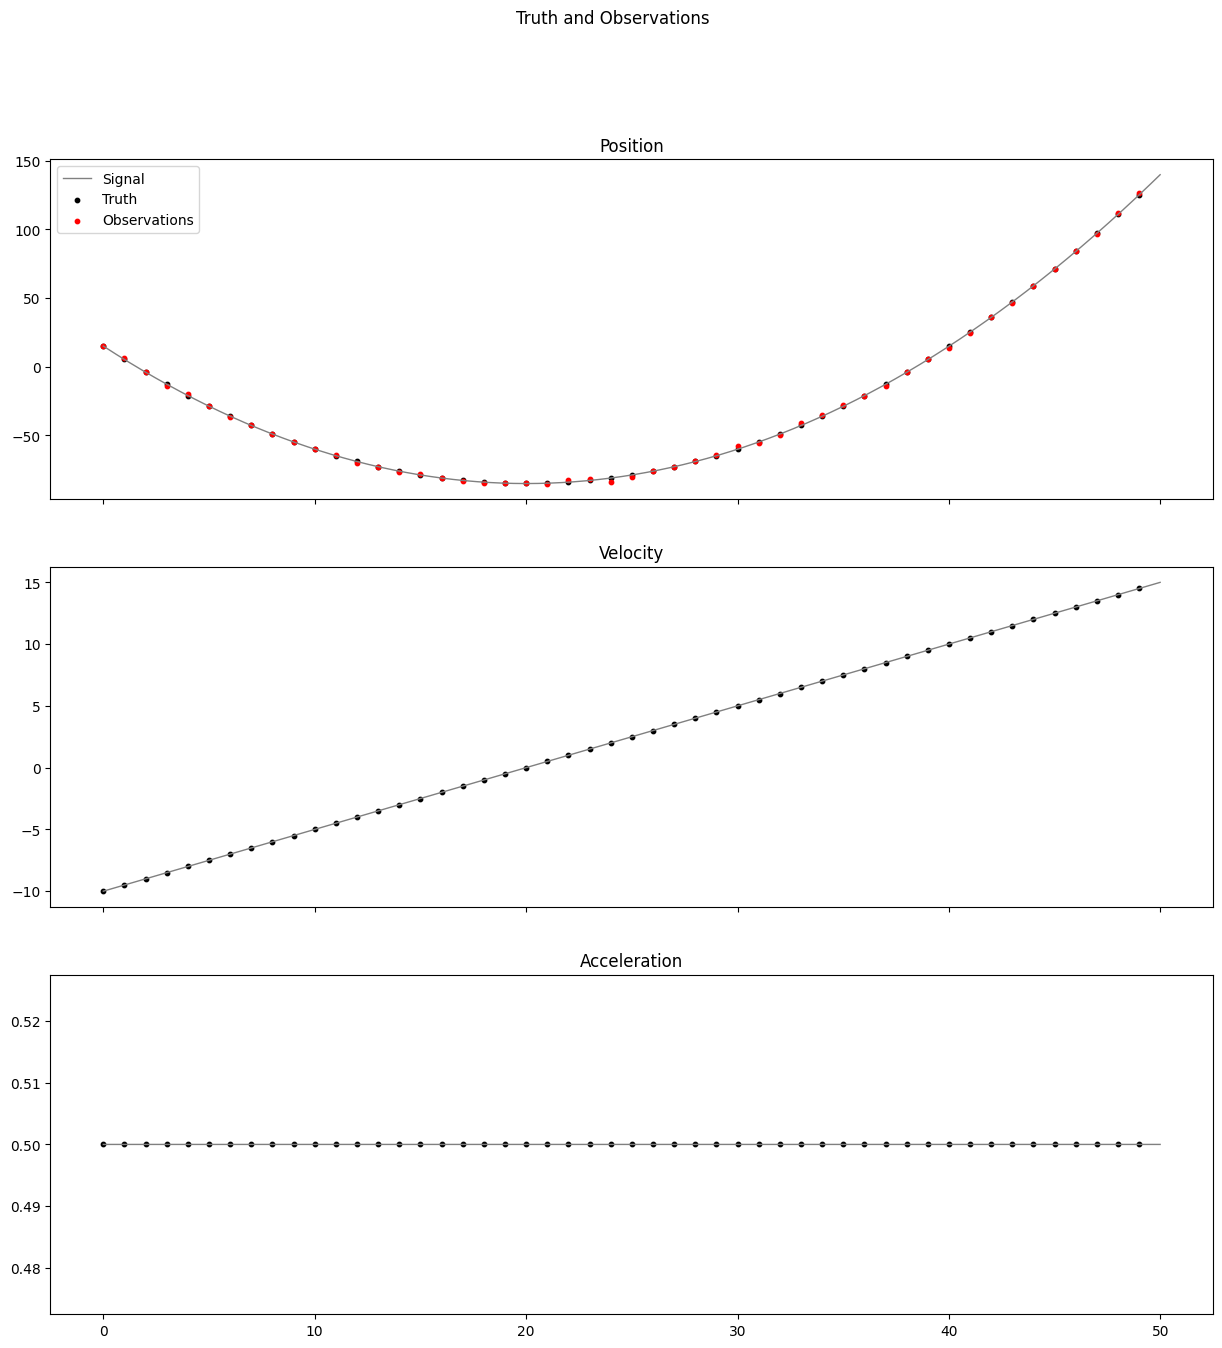

In [10]:
# Plot the true signal and observations.
fig, axs = plt.subplots(3, 1, sharex=True,figsize=(15, 15))
fig.suptitle("Truth and Observations")
axs[0].plot(t_cont, X_cont[0, :], color='gray', linewidth=1)
axs[0].scatter(t_dis, X_dis[0, :], s=10, color='k')
axs[0].scatter(t_dis, Y, s=10, color='r')
axs[0].legend(['Signal', 'Truth', 'Observations'])
axs[0].set_title("Position")
axs[1].plot(t_cont, X_cont[1, :], color='gray', linewidth=1)
axs[1].scatter(t_dis, X_dis[1, :], s=10, color='k')
axs[1].set_title("Velocity")
axs[2].plot(t_cont, X_cont[2, :], color='gray', linewidth=1)
axs[2].scatter(t_dis, X_dis[2, :], s=10, color='k')
axs[2].set_title("Acceleration")
plt.show()

In [11]:
'''The Kalman filter is used to estimate the state of the system.'''
m_prior = m_false
R_prior = R0

K = R_prior@H.T@np.linalg.inv(H@R_prior@H.T + R_obs)

# The mean is updated using the Joseph form of the Kalman filter.
m_post = np.zeros((3, len(t_dis)))
m_post[:, 0] = m_prior + K@(Y[:, 0] - H@m_prior)

# The covariance matrix is updated using the Joseph form of the Kalman filter.
R_post = np.zeros((3, 3, len(t_dis)))
R_post[:, :, 0] = R_prior - K@(H@R_prior@H.T + R_obs)@K.T

# The Kalman filter is run for the rest of the time steps.
R_fwd = 0
for i_time in range(0, len(t_dis)-1):
    m_prior = F@m_post[:, i_time]
    R_prior = F@R_post[:, :, i_time].squeeze()@F.T + R_fwd
    
    K = R_prior@H.T@np.linalg.inv(H@R_prior@H.T + R_obs)

    m_post[:, i_time+1] = m_prior + K@(Y[:, i_time+1] - H@m_prior)
    R_post[:, :, i_time+1] = R_prior - K@(H@R_prior@H.T + R_obs)@K.T


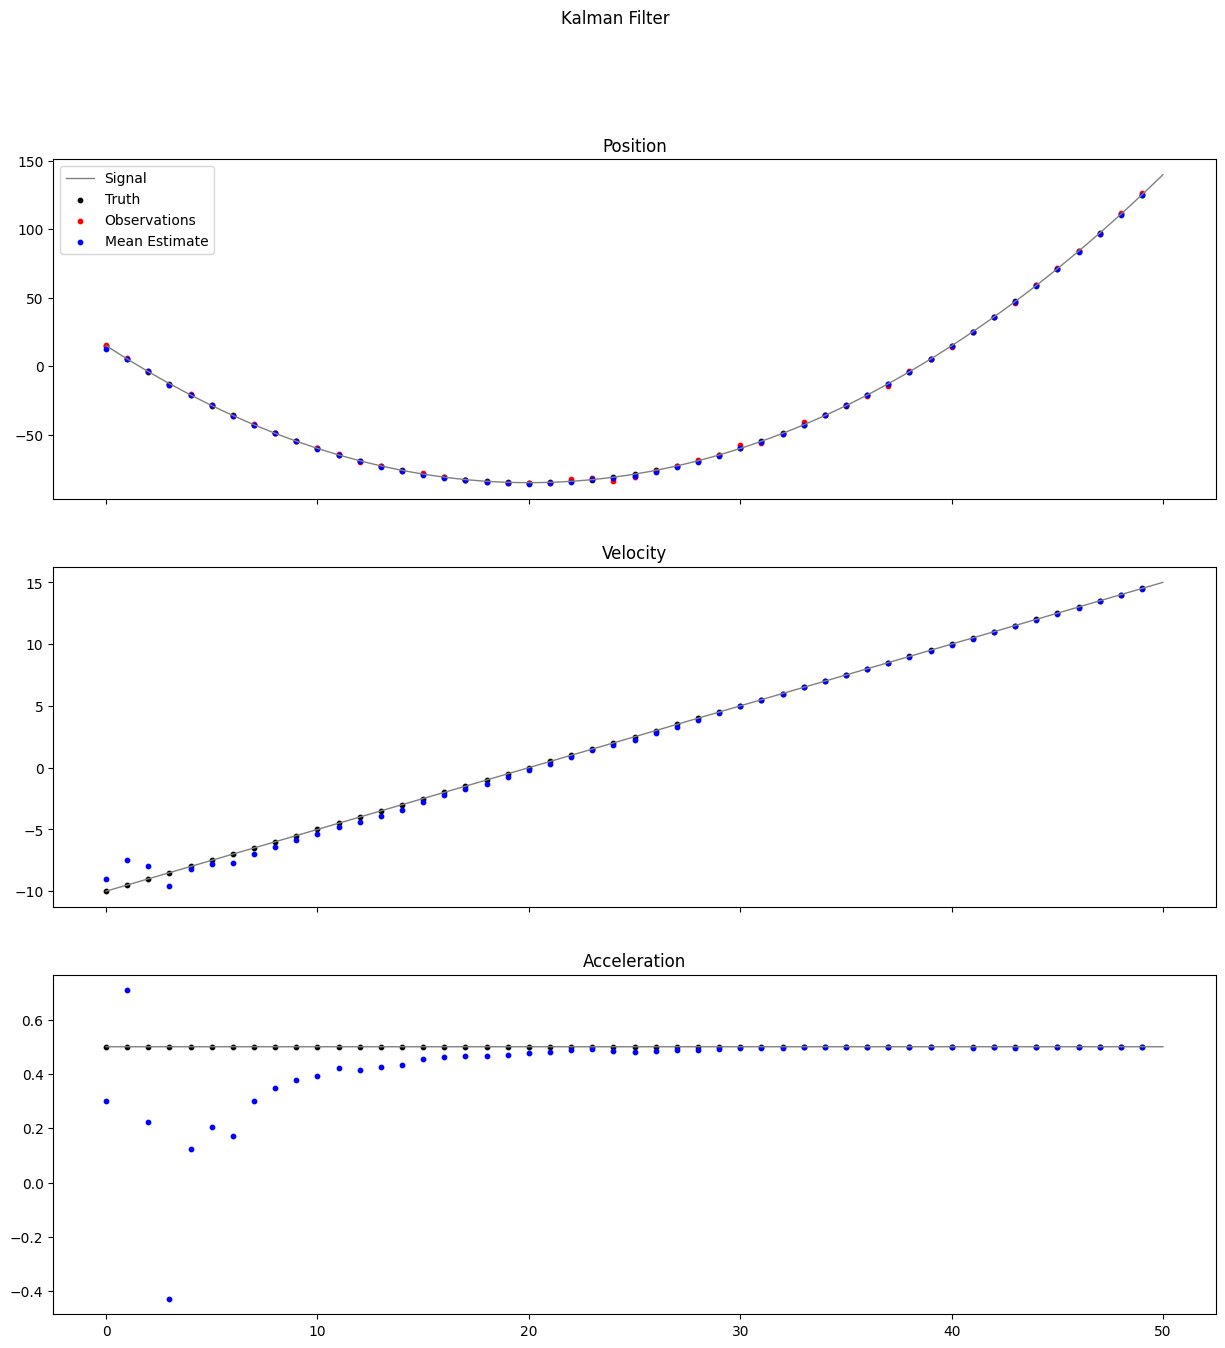

In [12]:
# Plot the true signal, observations, and the Kalman filter estimate.
fig, axs = plt.subplots(3, 1, sharex=True,figsize=(15, 15))
fig.suptitle("Kalman Filter")
axs[0].plot(t_cont, X_cont[0, :], color='gray', linewidth=1)
axs[0].scatter(t_dis, X_dis[0, :], s=10, color='k')
axs[0].scatter(t_dis, Y, s=10, color='r')
axs[0].scatter(t_dis, m_post[0, :], s=10, color='b')
axs[0].legend(['Signal', 'Truth', 'Observations', 'Mean Estimate'])
axs[0].set_title("Position")
axs[1].plot(t_cont, X_cont[1, :], color='gray', linewidth=1)
axs[1].scatter(t_dis, X_dis[1, :], s=10, color='k')
axs[1].scatter(t_dis, m_post[1, :], s=10, color='b')
axs[1].set_title("Velocity")
axs[2].plot(t_cont, X_cont[2, :], color='gray', linewidth=1)
axs[2].scatter(t_dis, X_dis[2, :], s=10, color='k')
axs[2].scatter(t_dis, m_post[2, :], s=10, color='b')
axs[2].set_title("Acceleration")
plt.show()